In [55]:
import numpy as np 
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, log_loss, matthews_corrcoef, balanced_accuracy_score,
    precision_recall_curve, auc
)
from imblearn.over_sampling import SMOTE


In [56]:
#Load data
results_production = pd.read_csv('results_production.csv', delimiter=',') 
results_unit_commitment = pd.read_csv('results_unit_comitment.csv', delimiter=',')

In [57]:
results_production.head()

,hour,generation 1,generation 2,generation 3,wind generation 1,wind generation 2,load 1,load 2,load 3,epsilon 1,...,transmission_up_binding_L3,transmission_down_binding_L3,transmission_up_binding_L4,transmission_down_binding_L4,transmission_up_binding_L5,transmission_down_binding_L5,transmission_up_binding_L6,transmission_down_binding_L6,transmission_up_binding_L7,transmission_down_binding_L7
0,0,100.0,0.0,17.444091,0.0,26.718066,9.010135,72.081078,63.070944,0.0,...,True,False,False,False,False,False,False,False,False,False
1,1,100.0,0.0,13.962864,0.0,22.242203,8.512817,68.102534,59.589717,0.0,...,True,False,False,False,False,False,False,False,False,False
2,2,100.0,0.0,14.725975,0.0,23.223346,8.621833,68.974661,60.352828,0.0,...,True,False,False,False,False,False,False,False,False,False
3,3,100.0,0.0,10.192372,0.0,17.394428,7.974175,63.793400,55.819225,0.0,...,True,False,False,False,False,False,False,False,False,False
4,4,100.0,0.0,0.000000,0.0,8.846430,6.851523,54.812183,47.960660,0.0,...,True,False,False,False,False,False,False,False,False,False


In [58]:
features = results_production[['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3']]
# Use the unit commitment results as labels
labels = results_unit_commitment[['G1', 'G2', 'G3']]

# Separate features (X) and labels (y)
X = features
y = labels


# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")


Training Set: (8400, 5), Validation Set: (1800, 5), Test Set: (1800, 5)


In [59]:
# Check if units are always ON or OFF
print(y_train.mean())  # If mean = 1 or 0, the unit is always ON or OFF

# Units to classify
units_to_classify = [col for col in labels.columns if 0 < y_train[col].mean() < 1]
print(f"Units to classify: {units_to_classify}")

G1    1.000000
G2    0.226310
G3    0.903214
dtype: float64
Units to classify: ['G2', 'G3']


In [60]:
# Apply SMOTE for each generator


smote = SMOTE(random_state=42)
X_train_smote = {}
y_train_smote = {}

for unit in units_to_classify:
    print(f"Applying SMOTE for {unit}...")
    X_res, y_res = smote.fit_resample(X_train, y_train[unit])
    X_train_smote[unit] = X_res
    y_train_smote[unit] = y_res


Applying SMOTE for G2...
Applying SMOTE for G3...


In [61]:
# Linear Classifier
# Train logistic regression models using SMOTE-balanced data
logistic_models = {}

for unit in units_to_classify:
    model = LogisticRegression(random_state=42)
    model.fit(X_train_smote[unit], y_train_smote[unit])
    logistic_models[unit] = model



In [62]:
## Non-Linear Classifier
# Define SVM models for each generator with multiple kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
# Train SVM models using SMOTE-balanced data
svm_models = {kernel: {} for kernel in kernels}

for kernel in kernels:
    for unit in units_to_classify:
        model = SVC(kernel=kernel, class_weight='balanced', random_state=42)
        model.fit(X_train_smote[unit], y_train_smote[unit])
        svm_models[kernel][unit] = model



In [63]:
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, matthews_corrcoef

# Evaluation Function
def evaluate_model(model, X, y, units, model_type, kernel=None):
    """Evaluate a model and print metrics, including Balanced Accuracy and MCC."""
    results = {}
    for unit in units:
        # Predict labels
        y_pred = model[unit].predict(X) if kernel is None else model[kernel][unit].predict(X)
        
        # Compute metrics
        accuracy = accuracy_score(y[unit], y_pred)
        bal_accuracy = balanced_accuracy_score(y[unit], y_pred)
        mcc = matthews_corrcoef(y[unit], y_pred)
        report = classification_report(y[unit], y_pred, output_dict=True)
        
        # Print metrics
        print(f"\n{model_type} ({'Kernel: ' + kernel if kernel else ''}) - {unit}")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Balanced Accuracy: {bal_accuracy:.3f}")
        print(f"MCC: {mcc:.3f}")
        print(classification_report(y[unit], y_pred))
        
        # Store results
        results[unit] = {
            "accuracy": accuracy,
            "balanced_accuracy": bal_accuracy,
            "mcc": mcc,
            "report": report
        }
    return results

# Logistic Regression Evaluation
logistic_results = evaluate_model(logistic_models, X_test, y_test, units_to_classify, model_type="Logistic Regression")

# SVM Evaluation for all kernels
svm_results = {}
for kernel in kernels:
    print(f"\nEvaluating SVM ({kernel} kernel)...")
    svm_results[kernel] = evaluate_model(svm_models, X_test, y_test, units_to_classify, model_type="SVM", kernel=kernel)



Logistic Regression () - G2
Accuracy: 0.844
Balanced Accuracy: 0.845
MCC: 0.613
              precision    recall  f1-score   support

         0.0       0.95      0.84      0.90      1422
         1.0       0.59      0.85      0.70       378

    accuracy                           0.84      1800
   macro avg       0.77      0.85      0.80      1800
weighted avg       0.88      0.84      0.85      1800


Logistic Regression () - G3
Accuracy: 1.000
Balanced Accuracy: 1.000
MCC: 1.000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       161
         1.0       1.00      1.00      1.00      1639

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800


Evaluating SVM (linear kernel)...

SVM (Kernel: linear) - G2
Accuracy: 0.847
Balanced Accuracy: 0.838
MCC: 0.608
              precision    recall  f1-score   support

         0.0   

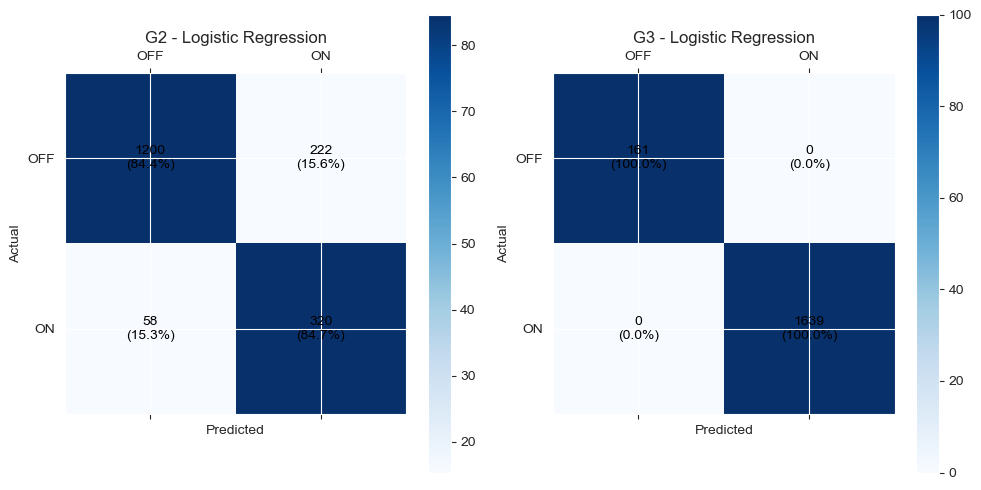

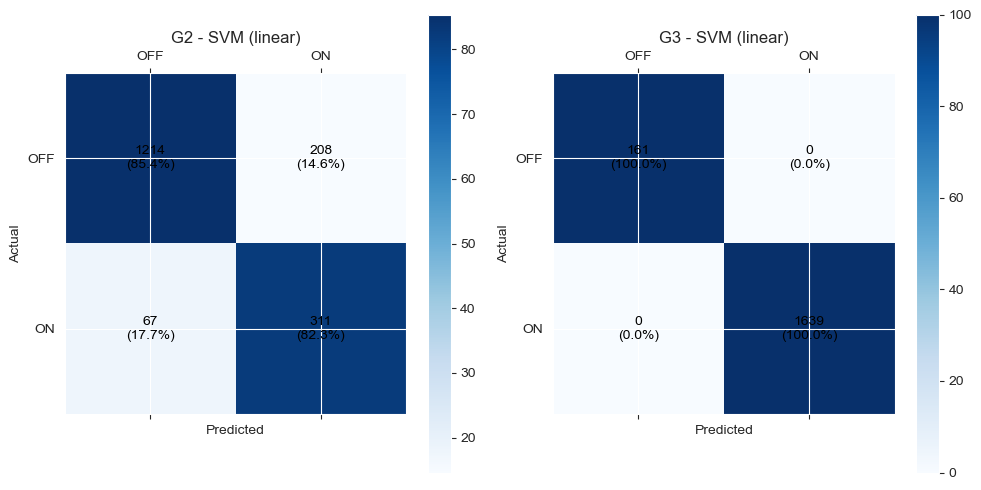

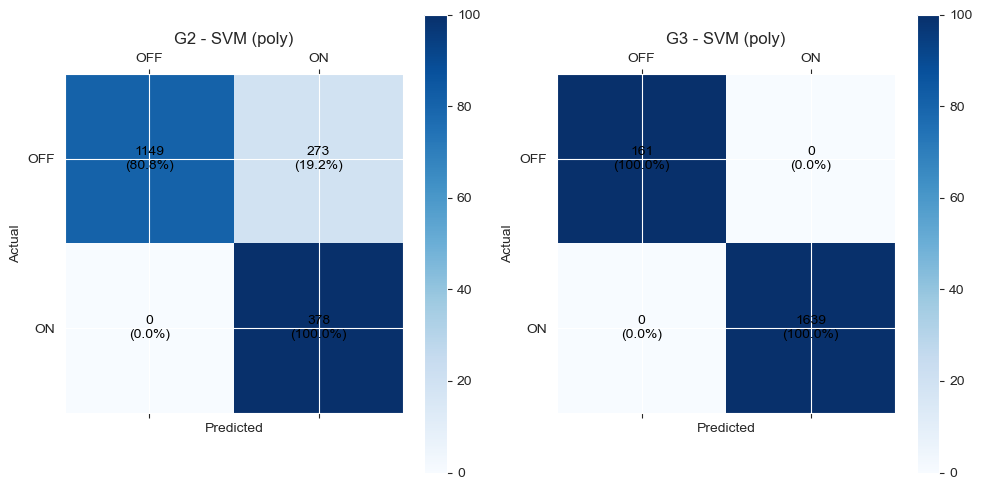

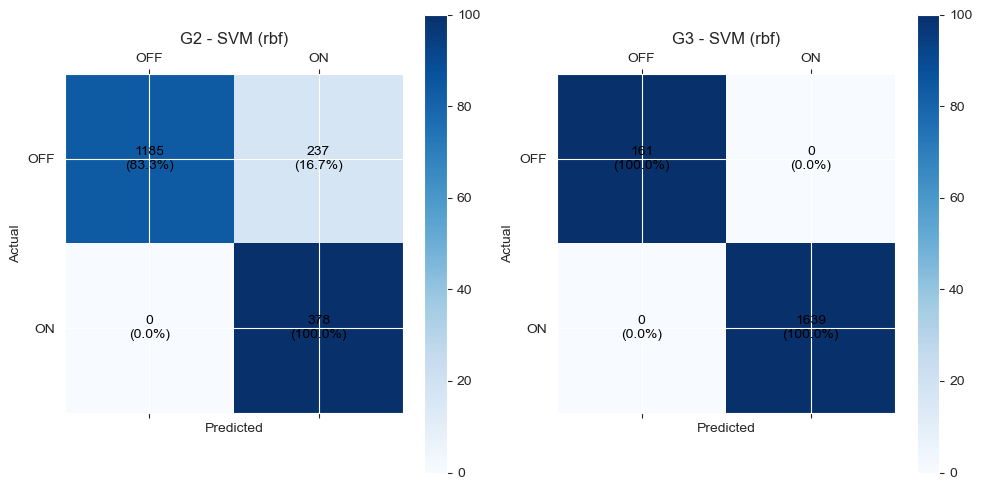

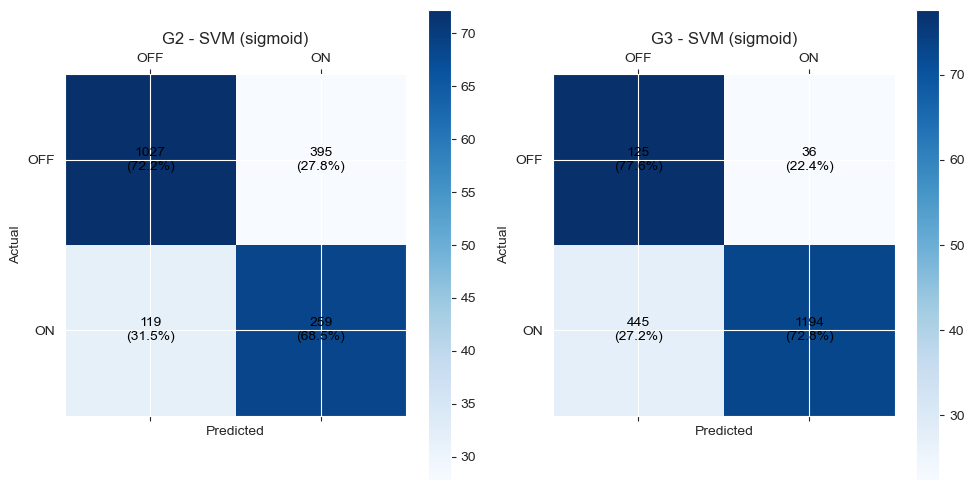

In [64]:
# Visualization: Confusion Matrices
def plot_confusion_matrices(models, units, model_type, X, y, kernels=None):

    if model_type == "Logistic Regression":
        fig, axes = plt.subplots(1, len(units), figsize=(5 * len(units), 5))
        for idx, unit in enumerate(units):
            y_pred = models[unit].predict(X)
            cm = confusion_matrix(y[unit], y_pred)
            ax = axes[idx] if len(units) > 1 else axes
            plot_confusion_matrix_on_ax(cm, ['OFF', 'ON'], ax, title=f"{unit} - {model_type}", text_color='black')
        plt.tight_layout()
        plt.show()
    elif model_type == "SVM":
        for kernel in kernels:
            fig, axes = plt.subplots(1, len(units), figsize=(5 * len(units), 5))
            for idx, unit in enumerate(units):
                y_pred = models[kernel][unit].predict(X)
                cm = confusion_matrix(y[unit], y_pred)
                ax = axes[idx] if len(units) > 1 else axes
                plot_confusion_matrix_on_ax(cm, ['OFF', 'ON'], ax, title=f"{unit} - SVM ({kernel})", text_color='black')
            plt.tight_layout()
            plt.show()

def plot_confusion_matrix_on_ax(cm, classes, ax, title, cmap='Blues', text_color='black'):
    """
    Helper function to plot a confusion matrix on an axis.

    """
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cax = ax.matshow(cm_percentage, cmap=cmap)
    ax.figure.colorbar(cax, ax=ax)
    
    # Annotate cells with count and percentage
    for (i, j), value in np.ndenumerate(cm):
        ax.text(j, i, f"{value}\n({cm_percentage[i, j]:.1f}%)", ha="center", va="center", color=text_color)
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Plot Confusion Matrices
plot_confusion_matrices(logistic_models, units_to_classify, "Logistic Regression", X_test, y_test)
plot_confusion_matrices(svm_models, units_to_classify, "SVM", X_test, y_test, kernels=kernels)
